In [13]:
import numpy as np
from scipy import linalg

In [14]:
class newmark_beta:
    # This class simplifies the structural model to a frame structure using the Newmark Beta method.
    # Attributes:
    #   self.m_matrax: Mass matrix (diagonal)
    #   self.k_matrix: Stiffness matrix
    #   self.w_n: Natural frequencies (Hz) for different modes
    #   self.c_matrax: Damping matrix
    #   self.t: Time vector [1, nt+1]
    #   self.d: Displacement matrix [number of floors, nt+1]
    #   self.v: Velocity matrix [number of floors, nt+1]
    #   self.a: Acceleration matrix [number of floors, nt+1]
    def __init__(self, m, k, zeta, nt, dt, force, gama_newmark=0.5, beta_newmark=0.25):
        # m: List of masses simplified to a cantilever beam (from bottom to top)
        # k: List of stiffness values simplified to a cantilever beam (from bottom to top)
        # zeta: Damping ratio
        # nt: Total number of time steps
        # dt: Time increment for each step
        # force: External force matrix, with shape (number of floors, nt); i: floor index, j: time step index
        # gama_newmark: Newmark Beta method parameter (typically 0.5 for stability)
        # beta_newmark: Newmark Beta method parameter (typically 0.25 for stability)
        if len(m) != len(k):
            print('The lengths of mass and stiffness lists are different.')
            quit()

        num = len(k)
        self.m_matrax = np.diag(m)  # Construct mass matrix as a diagonal matrix

        # Construct the stiffness matrix
        k_matrix = np.zeros((num, num))
        for i in range(num):
            if i == 0:
                k_matrix[i][i] = k[0] + k[1]
                k_matrix[i][i+1] = -k[1]
            elif i == num - 1:
                k_matrix[i][i] = k[-1]
                k_matrix[i][i-1] = -k[-1]
            else:
                k_matrix[i][i-1] = -k[i]
                k_matrix[i][i] = k[i] + k[i+1]
                k_matrix[i][i+1] = -k[i+1]
        self.k_matrix = k_matrix  # Stiffness matrix

        # Calculate natural frequencies (Hz) from the generalized eigenvalue problem
        self.w_n = 1 / np.sqrt(linalg.eigvals(self.m_matrax, k_matrix).real) / (2 * np.pi)

        # Calculate the damping matrix using proportional damping
        omiga = self.w_n[0] * 2 * np.pi  # Fundamental circular frequency (rad/s)
        alpha = omiga * zeta  # Damping coefficient alpha
        beta = zeta / omiga   # Damping coefficient beta
        self.c_matrax = alpha * self.m_matrax + beta * k_matrix  # Damping matrix

        # Newmark Beta method coefficients
        a0 = 1 / (beta_newmark * dt * dt)
        a1 = gama_newmark / (beta_newmark * dt)
        a2 = 1 / (beta_newmark * dt)
        a3 = 1 / (2 * beta_newmark) - 1
        a4 = gama_newmark / beta_newmark - 1
        a5 = dt / 2 * (gama_newmark / beta_newmark - 2)
        a6 = dt * (1 - gama_newmark)
        a7 = dt * gama_newmark

        # Initialize time, displacement, velocity, and acceleration arrays
        self.t = np.zeros([1, nt + 1])  # Time vector
        self.d = np.zeros([num, nt + 1])  # Displacement matrix (floors x time steps)
        self.v = np.zeros([num, nt + 1])  # Velocity matrix (floors x time steps)
        self.a = np.zeros([num, nt + 1])  # Acceleration matrix (floors x time steps)
        
        # note that a v d are all initialized to zero at time 0

        # Calculate the equivalent stiffness matrix for Newmark Beta integration
        ke = k_matrix + a0 * self.m_matrax + a1 * self.c_matrax

        # Time-stepping integration loop
        for j in range(1, nt + 1):
            self.t[0][j] = j * dt  # Update time
            fe = (np.reshape(force[:, j - 1], [num, 1]) +
                  np.dot(self.m_matrax, np.reshape((a0 * self.d[:, j - 1] +
                                                     a2 * self.v[:, j - 1] +
                                                     a3 * self.a[:, j - 1]), [num, 1])) +
                  np.dot(self.c_matrax, np.reshape((a1 * self.d[:, j - 1] +
                                                     a4 * self.v[:, j - 1] +
                                                     a5 * self.a[:, j - 1]), [num, 1])))
            self.d[:, j] = np.reshape(np.dot(np.linalg.inv(ke), fe), [1, num])
            self.a[:, j] = a0 * (self.d[:, j] - self.d[:, j - 1]) - a2 * self.v[:, j - 1] - a3 * self.a[:, j - 1]
            self.v[:, j] = self.v[:, j - 1] + a6 * self.a[:, j - 1] + a7 * self.a[:, j]


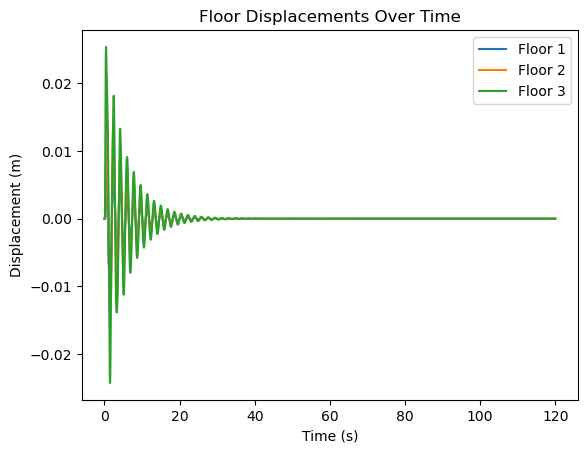

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Define system parameters for a 3-story building
m = np.array([1000, 800, 600])        # Masses (kg) for each floor (from bottom to top)
k = np.array([50000, 40000, 30000])     # Stiffnesses (N/m) for each floor
zeta = 0.05                           # Damping ratio
nt = 12000                            # Total number of time steps
dt = 0.01                             # Time increment (s)

# Create an external force matrix with shape (3, nt)
# For example, apply a force of 1000 N on the top floor between time steps 10 and 20
force = np.zeros((3, nt))
force[2, 10:21] = 1000

# Create an instance of newmark_beta with the given parameters
nm = newmark_beta(m, k, zeta, nt, dt, force)

# Plot the displacement responses for each floor over time
time = nm.t.flatten()  # Convert time vector to 1D array for plotting
plt.figure()
for i in range(len(m)):
    plt.plot(time, nm.d[i, :], label=f'Floor {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('Floor Displacements Over Time')
plt.legend()
plt.show()


第 1 层的主频为: 0.5859375 Hz


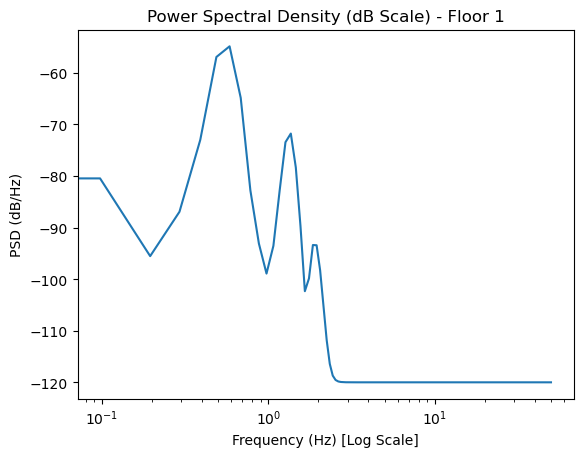

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# Select the floor data to analyze (0 for the first floor, 1 for the second, etc.)
floor_index = 0  # Analyze the first floor

# Extract the displacement data for the selected floor
displacement = nm.d[floor_index, :]

# Sampling frequency determined by dt
fs = 1 / dt

# Estimate PSD using Welch's method; nperseg can be adjusted based on data length
freq, psd = welch(displacement, fs=fs, nperseg=1024)

# Convert PSD to dB scale; add a small value eps to avoid log(0)
eps = 1e-12
psd_db = 10 * np.log10(psd + eps)

# Find the dominant frequency by locating the frequency corresponding to the maximum PSD
dominant_index = np.argmax(psd)
dominant_frequency = freq[dominant_index]
print("The dominant frequency of floor", floor_index + 1, "is:", dominant_frequency, "Hz")

# Plot the PSD: the x-axis is in log scale
plt.figure()
plt.semilogx(freq, psd_db)  # Use semilogx to convert the x-axis to a logarithmic scale
plt.xlabel('Frequency (Hz) [Log Scale]')
plt.ylabel('PSD (dB/Hz)')
plt.title('Power Spectral Density (dB Scale) - Floor ' + str(floor_index + 1))
plt.show()
